In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['student-data.csv']


# Getting Started

Goal of the project: To identify students who might need early intervention i.e to predict whether the student will pas or fail.

The dataset: Let's see the columns of the dataset.

* school:  "student's school",
* sex: "student's sex",
* age: "student's age"
* address: "student's home address type"
* famsize: "family size"
* Pstatus: "parent's cohabitation status"
* Medu: "mother's education"
* Fedu: "father's education"
* Mjob: "mother's job"
* Fjob: "father's job"
* reason: "reason to choose this school"
* guardian: "student's guardian"
* traveltime: "home to school travel time"
* studytime: "weekly study time"
* failures: "number of past class failures"
* schoolsup: "extra educational support"
* famsup: "family educational support"
* paid: "extra paid classes within the course subject"
* activities: "extra-curricular activities"
* nursery: "attended nursery school"
* higher: "wants to take higher education"
* internet: "Internet access at home"
* romantic: "with a romantic relationship"
* famrel: "quality of family relationships"
* freetime: "free time after school"
* goout: "going out with friends"
* Dalc: "workday alcohol consumption"
* Walc: "weekend alcohol consumption"
* health: "current health status"
* absences: "number of school absences"
* passed": "did the student pass the final exam"

So we do have all total 30 featres to predict whether a student pass or fail.  so the target variable is "passed". Now it's time to explore the data.


# Data Exploration

In [2]:
# importing librararies
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')

In [3]:
# reading the data
student_data = pd.read_csv('../input/student-data.csv')
display(student_data.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,yes


## Finding out the following
* Total number of students
* Total numbe of students passed and failed
* Total number of features
* Graduation rate of the class

In [4]:
n_students = student_data.shape[0]
stud_passed = student_data['passed'].value_counts().loc['yes']
stud_failed = student_data['passed'].value_counts().loc['no']
n_features = student_data.shape[1]
grad_rate = ( stud_passed / float(stud_passed + stud_failed) ) * 100
print("Number of students: ", n_students)
print("Number of students passed: ", stud_passed)
print("Number of students failed: ", stud_failed)
print("Total number of features: ", n_features)
print("Graduation rate: ", round(grad_rate, 2))

Number of students:  395
Number of students passed:  265
Number of students failed:  130
Total number of features:  31
Graduation rate:  67.09


# Prepare the data

Divide our dataset into features and target, so for us the target columns is 'passed'. 
1. Split dataset into features and target 
2. Converting non-numeric columns to numeric
3.  Spliting the whole dataset into training and testing 


In [5]:
X_feature = student_data.drop('passed', axis='columns')
y_target = student_data['passed']

features = list(X_feature.columns)
target = student_data.columns[-1]

print("Features are: ")
for i, feature in enumerate(features):
    print(i+1, " ", feature)
    
print("\nTarget is: ", target)

Features are: 
1   school
2   sex
3   age
4   address
5   famsize
6   Pstatus
7   Medu
8   Fedu
9   Mjob
10   Fjob
11   reason
12   guardian
13   traveltime
14   studytime
15   failures
16   schoolsup
17   famsup
18   paid
19   activities
20   nursery
21   higher
22   internet
23   romantic
24   famrel
25   freetime
26   goout
27   Dalc
28   Walc
29   health
30   absences

Target is:  passed


## Preprocessing features

As we can see, there are several features which are non-numeric. And some features are categorical variable . To handle those categorical variable we will use pandas get_dummies() to create dummy variables and columns with binary variables to 0/1.

In [6]:
def preprocess_features(X_feature):
    """Convert binary value features into 0/1 and categorical non numeric variables to dummy variables"""
    
    # initialize the new dataframe i.e output
    output_df = pd.DataFrame(index=X_feature.index)
    
    # iterate through each feature column
    for col, col_data in X_feature.iteritems():
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)
            
        output_df = output_df.join(col_data)
    
    return output_df
X_feature = preprocess_features(X_feature)
print("Number of columns after precprocessing: {}, \n{}".format(len(X_feature.columns), 
                                                                list(X_feature.columns)))

Number of columns after precprocessing: 48, 
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


## Splitting data into train and test set

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size = 0.25, 
                                                    stratify=y_target, random_state=42)
print("Training set size: {}".format(len(X_train)))
print("Test set size: {}".format(len(X_test)))

Training set size: 296
Test set size: 99


# Exploratory Data Analysis

Now we have a separate test set and we are not going to touch that until we found a good model to testify. Untill that time let's explore what the training data has to offer.

In [8]:
def plot_categorical(df, count_col='passed', plots_per_row=3):
    df_cat = df.select_dtypes(include=['object'])
    
    for i, col in enumerate(df_cat.columns):
        plot_index = i % plots_per_row
        
        if plot_index == 0:
            f, axes = plt.subplots(1, plots_per_row, figsize=(15, 5))
            sns.despine(left=True)
        sns.countplot(x=col, hue=count_col, data=df, ax=axes[plot_index])
        
        

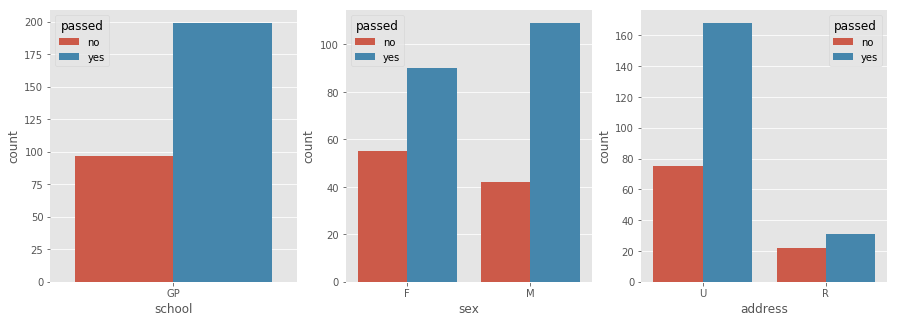

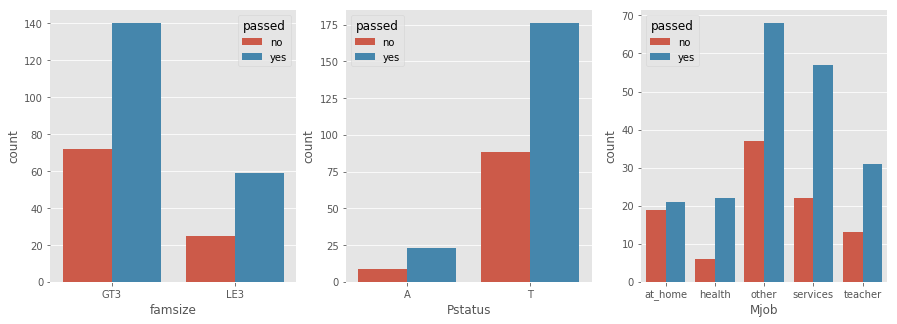

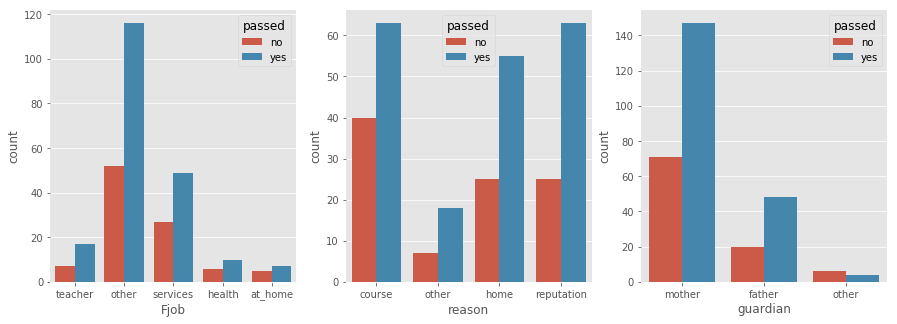

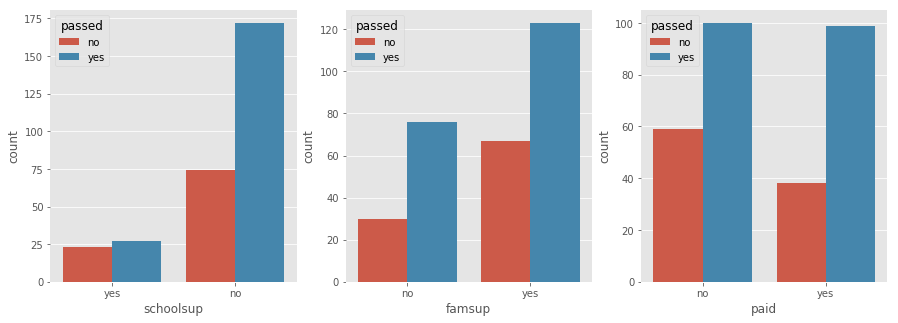

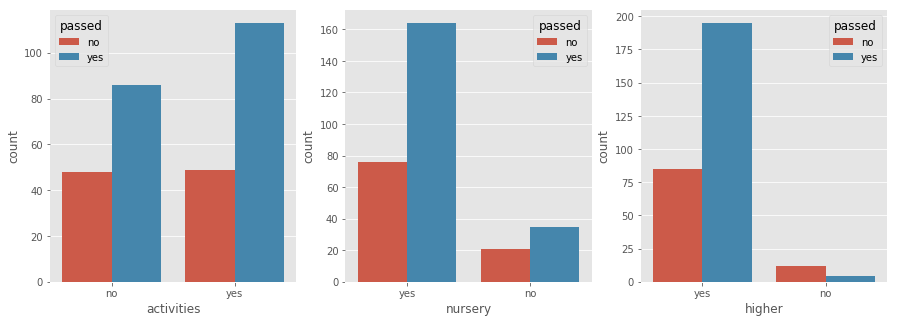

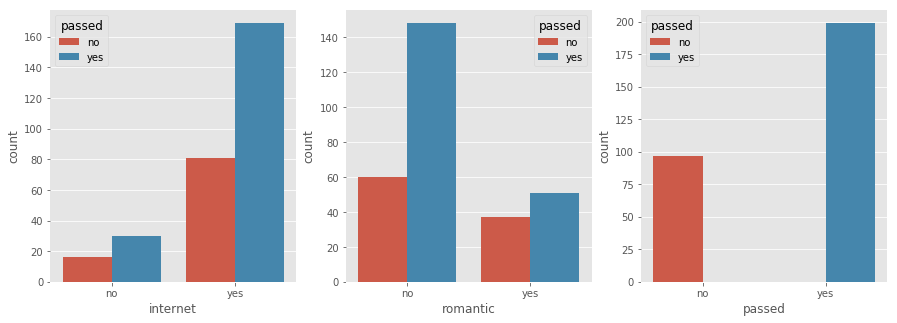

In [9]:
df = student_data.iloc[:296, :]
plot_categorical(df)

A nice visualiztion to understand how these variables varies with our target class labels.
* Look at the internet feature, the distibution is not balanced at all, those who have an internet connection are passed twice as of those who haven't passed. So as those who havenot internet connection the number of student pass is more than number of student failed. So in both cases these seems to draw same conclusion which leads no where.
* Let's take the higher education feature, students wants to persue higher education has higher chance of passing the exam compared to a negligible count for those who wants to persue higher education but somehow failed.
* Have a look at the paid feature, which tells us about student subscribe to extra paid classes, in that if we look at the graph then either student took paid courses or not the number of passing is more in both the cases. So then it barely determines whether a student will pas or fail. Because whether a student took paid course or not the number of passing and failing count is almost same in both cases.

Like this many interesting information can be obtained from this graph. But the problem is we really cant determine which feature lead to where. In that case a good predictive model can tells us the answer. Before that let's have a look at the numeric variables.

In [10]:
def plot_numeric(df, col_t='passed', plots_per_row=2):
    df_num = df.select_dtypes(exclude=object)
    
    if not (col_t in df_num.columns):
        df_num = df_num.join(df[col_t])
    
    for i, col in enumerate(df_num.columns):
        if col == col_t:
            continue
        plot_idx = i % plots_per_row
        
        if plot_idx == 0:
            f, axes = plt.subplots(1, plots_per_row, figsize=(15, 5))
            sns.despine(left=True)
            
        # separating dataframe into pass and fail
        df_num_yes = df_num.loc[df_num[col_t] == 'yes']
        yes_label = '{0} - passed'.format(col)
        
        df_num_no = df_num.loc[df_num[col_t] == 'no']
        no_label = '{0} - Failed'.format(col)
        
        sns.kdeplot(df_num_yes[col], ax=axes[plot_idx], shade=True, label=yes_label)
        sns.kdeplot(df_num_no[col], ax=axes[plot_idx], shade=True, label=no_label)
        
        axes[plot_idx].set_title('Distribution of "{0}" \nfactored by "{1}"\nFeature:"{2}"  Target:"{3}"'
                                 .format(col, col_t, col, col_t))
        axes[plot_idx].set(xlabel=col)

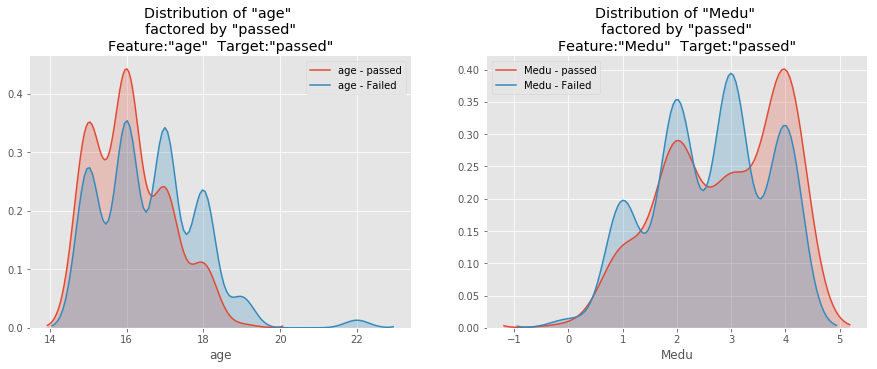

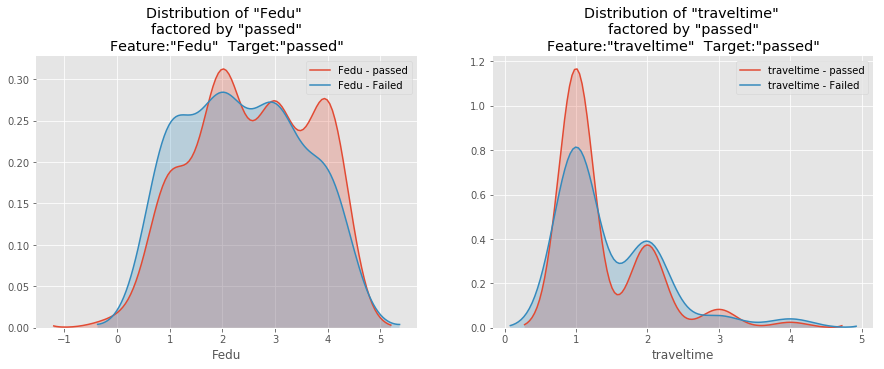

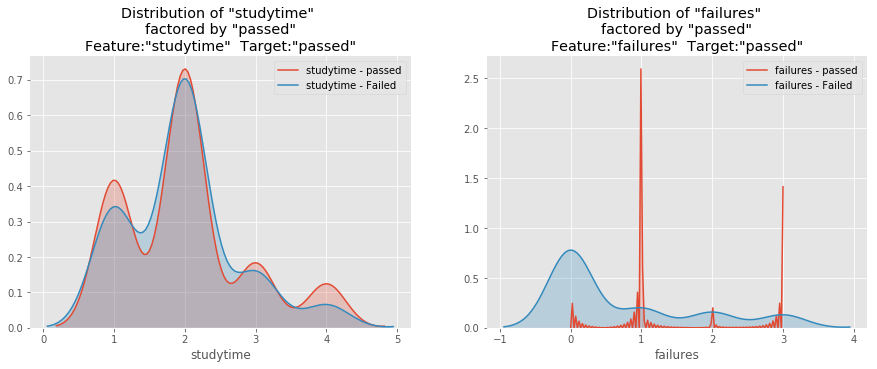

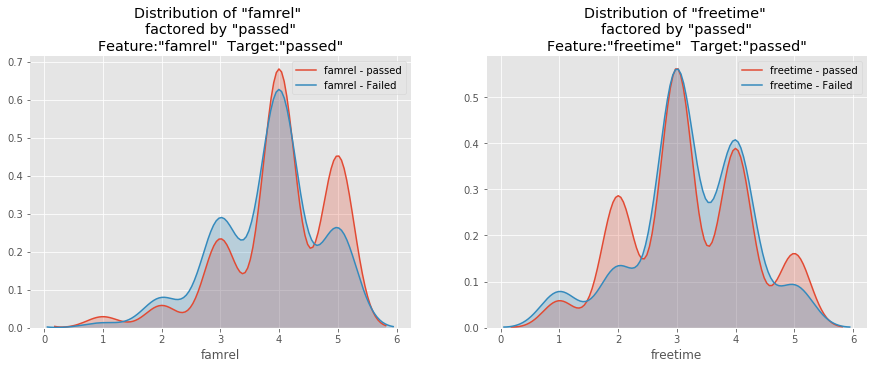

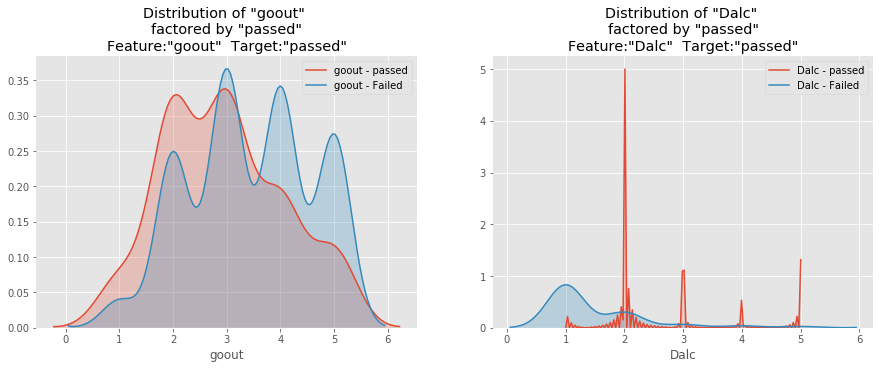

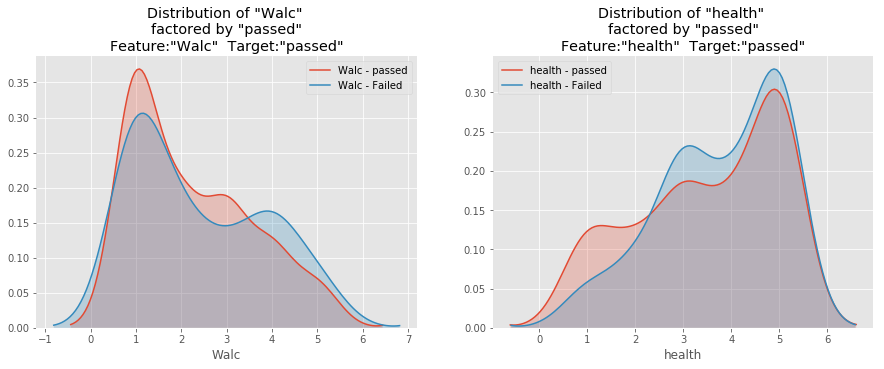

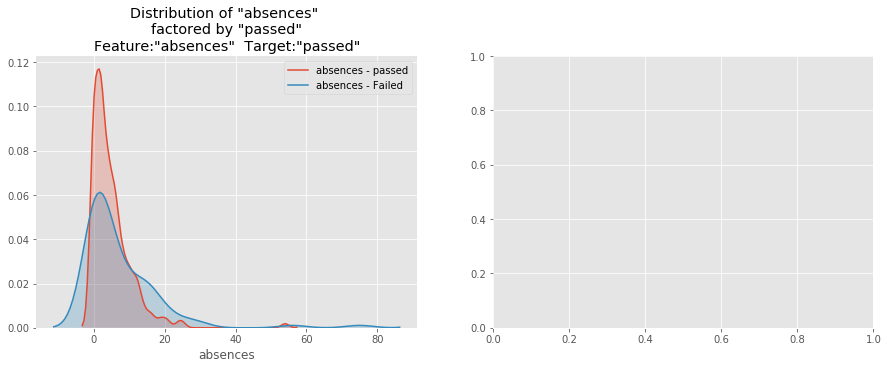

In [11]:
plot_numeric(df)

* Young students have a high probability of pass the exam while the graph shows studuent with age above 20 has a lower probability of failure.
* Student's mother having a higher education tells us that the student have greater chance of getting passed whereas student's mother having a primary education says that it has greater chance to get failed in exam.
* Is travel time a key factor? Yes but in this case it doesn't say much. As student travels less distance have higher probability of getting passed while the other side tells us that the mass distribution for less travel time with failed has also bit higher probability not as high as passed but it has.

We discovered both categorical and numerical distribution now let's build model to testify.

# Training and Evaluating models

In [12]:
# Training a model
import time

def train_classifier(clf, X_train, y_train, verbose=True):
    """
    Trains a classifier that is passed in to this function
    
    :param clf: sklearn model object
    :param X_train: feature dataframe object
    :param y_train: target variables
    :param verbose: flag to print training information
    """
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    train_time = end - start
    
    if verbose:
        print("Trained: {}".format(clf.__class__.__name__))
        print("Training time (secs)".format(train_time))
        
    return clf, train_time

In [13]:
# predictions on provided training and testing data set
def predict_labels(clf, features, target, verbose=True):
    """
    Predicts and calculate the f1_score for the given feature set using provided target values
    
    :param clf: sklearn model object
    :param features: feature set values
    :param target: target values
    
    """
    
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    
    prediction_time = end - start
    
    if verbose:
        print("predicted labels using {}".format(clf.__class__.__name__))
        print("Prediction time: {}".format(prediction_time))
        
    f1_measure = f1_score(target.values, y_pred, pos_label='yes')
    
    return f1_measure, prediction_time

In [14]:
def train_evaluate(clf, X_train, y_train, X_test, y_test, verbose=True):
    """
    Training and evaluation on training and test dataset
    :param clf: sklearn classfier object
    :param X_train: training feature dataset
    :param y_train: training target set
    :param X_test: test feature set
    :param y_test: test labels
    """
    
    clf, train_time = train_classifier(clf, X_train, y_train, verbose=verbose)
    train_f1, train_pred_time = predict_labels(clf, X_train, y_train, verbose=verbose)
    test_f1, test_pred_time = predict_labels(clf, X_test, y_test, verbose=verbose)
    
    print("F1 score on training set: {}".format(train_f1))
    print("F1 score on test set: {}".format(test_f1))
    
    f1_scores = {'F1_train': train_f1,
                'F1_test': test_f1}
    
    timings = {
        "Training_time": train_time,
        "prediction_train_time": train_pred_time,
        "prediction_test_time": test_pred_time
    }
    
    return clf, f1_scores, timings

In [15]:
def subset_train_predict(clf, X_train, y_train, X_test, y_test, subset_sizes, verbose=False):
    df_rows = []
    
    for i in subset_sizes:
        row = {'training_size': i}
        
        X_train_subset = X_train[:i]
        y_train_subset = y_train[:i]
        
        clf, f1_scores, timings = train_evaluate(clf, X_train, y_train, X_test, y_test, verbose=verbose)
        
        row.update(f1_scores)
        row.update(timings)
        
        df_rows.append(row)
        
    return pd.DataFrame(df_rows)

In [16]:
def plot_computation_time(df):
    fig, ax = plt.subplots(figsize=(12, 9))
    _ = ax.plot(df.training_size, df.Training_time, label="Training time")
    _ = ax.plot(df.training_size, df.prediction_train_time, label='Prediction time - Train')
    _ = ax.plot(df.training_size, df.prediction_test_time, label='Predtiction time - Test')
    _ = ax.legend(loc='upper-left')
    ax.set_xticks(subset_sizes)
    ax.set_xticklabels(subset_sizes, rotation=45)
    ax.set_xlabel('Training set size')
    ax.set_ylabel('seconds')
    ax.set_title('Training/Prediction times')
    plt.show()

In [17]:
def plot_f1_scores(df):
    fig, ax = plt.subplots(figsize=(12, 9))
    _ = ax.plot(df.training_size, df.F1_train, label='F1 scores - Training')
    _ = ax.plot(df.training_size, df.F1_test, label='F1 scores - Testing')
    _ = ax.legend(loc='upper-left')
    ax.set_xticks(subset_sizes)
    ax.set_xticklabels(subset_sizes, rotation=45)
    ax.set_xlabel('Training set size')
    ax.set_ylabel('F1 score')
    ax.set_title('F1 scores of each training samples')
    plt.show()

## Decision Tree

In [18]:
subset_sizes = range(100, 301, 10)
tree_model = subset_train_predict(DecisionTreeClassifier(), X_train, y_train,
                                 X_test, y_test, subset_sizes=subset_sizes)
tree_model

F1 score on training set: 1.0
F1 score on test set: 0.7286821705426357
F1 score on training set: 1.0
F1 score on test set: 0.6825396825396826
F1 score on training set: 1.0
F1 score on test set: 0.6923076923076923
F1 score on training set: 1.0
F1 score on test set: 0.6771653543307087
F1 score on training set: 1.0
F1 score on test set: 0.6666666666666666
F1 score on training set: 1.0
F1 score on test set: 0.6507936507936507
F1 score on training set: 1.0
F1 score on test set: 0.7086614173228346
F1 score on training set: 1.0
F1 score on test set: 0.672
F1 score on training set: 1.0
F1 score on test set: 0.6885245901639345
F1 score on training set: 1.0
F1 score on test set: 0.703125
F1 score on training set: 1.0
F1 score on test set: 0.6929133858267716
F1 score on training set: 1.0
F1 score on test set: 0.6393442622950819
F1 score on training set: 1.0
F1 score on test set: 0.6821705426356589
F1 score on training set: 1.0
F1 score on test set: 0.6825396825396826
F1 score on training set: 1.0

,F1_test,F1_train,Training_time,prediction_test_time,prediction_train_time,training_size
0,0.728682,1.0,0.003684,0.000680,0.000901,100
1,0.682540,1.0,0.003406,0.000611,0.000715,110
2,0.692308,1.0,0.002982,0.000568,0.000683,120
3,0.677165,1.0,0.002866,0.000602,0.000626,130
4,0.666667,1.0,0.003213,0.000596,0.000749,140
5,0.650794,1.0,0.003031,0.000590,0.000697,150
6,0.708661,1.0,0.003087,0.000581,0.000668,160
7,0.672000,1.0,0.003054,0.000565,0.000675,170
8,0.688525,1.0,0.003223,0.000574,0.000650,180
9,0.703125,1.0,0.002859,0.000566,0.000639,190


In [19]:
def plot_tree(tree_model, feature_names):
    with open("tree.dot", 'w') as f:
        export_graphviz(tree_model, out_file=f,
                       impurity=False,
                       rounded=True, 
                       filled=True,
                       leaves_parallel=False,
                       feature_names=feature_names, 
                       class_names=['fail', 'pass'])

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "upper-left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


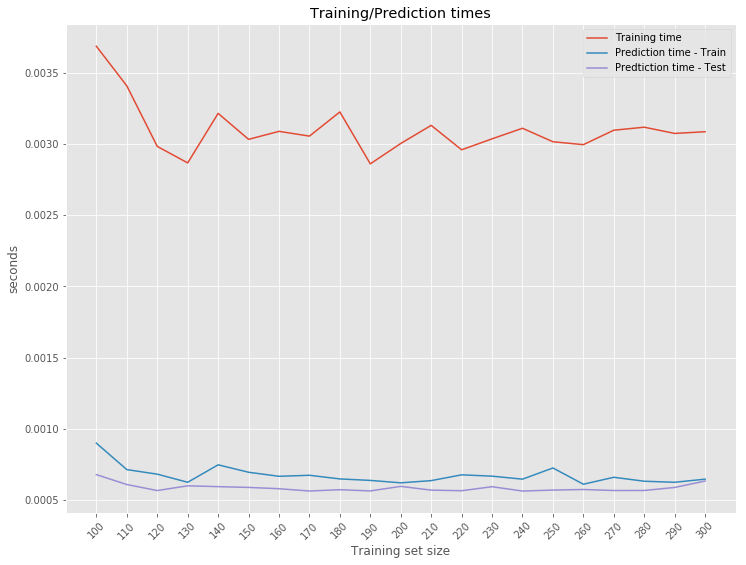

In [20]:
tree_stats = tree_model[20:21]
#tree_model.columns
plot_computation_time(tree_model)

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "upper-left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


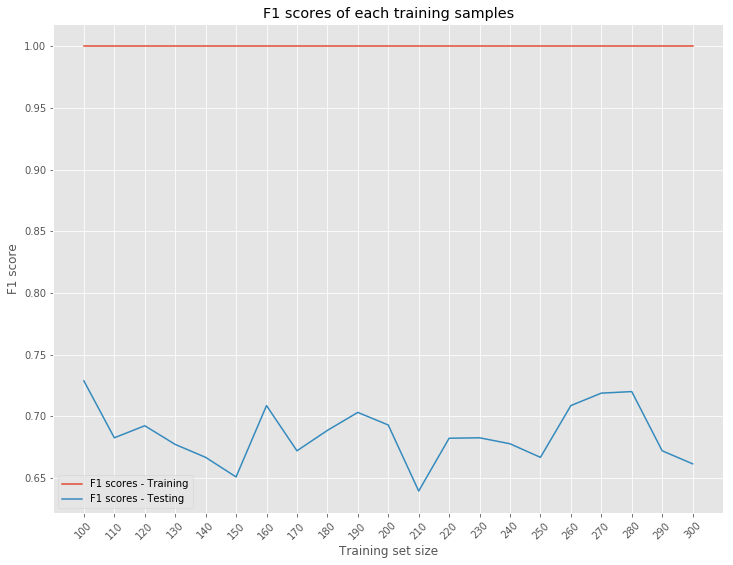

In [21]:
plot_f1_scores(tree_model)

In [22]:
tree_model, _, _ = train_evaluate(DecisionTreeClassifier(),
                                 X_train, y_train,
                                 X_test, y_test,
                                 verbose=False)

F1 score on training set: 1.0
F1 score on test set: 0.7076923076923077


In [23]:
plot_tree(tree_model, X_train.columns)

In [24]:
%%bash

dot -Tpng tree.dot -o tree.png

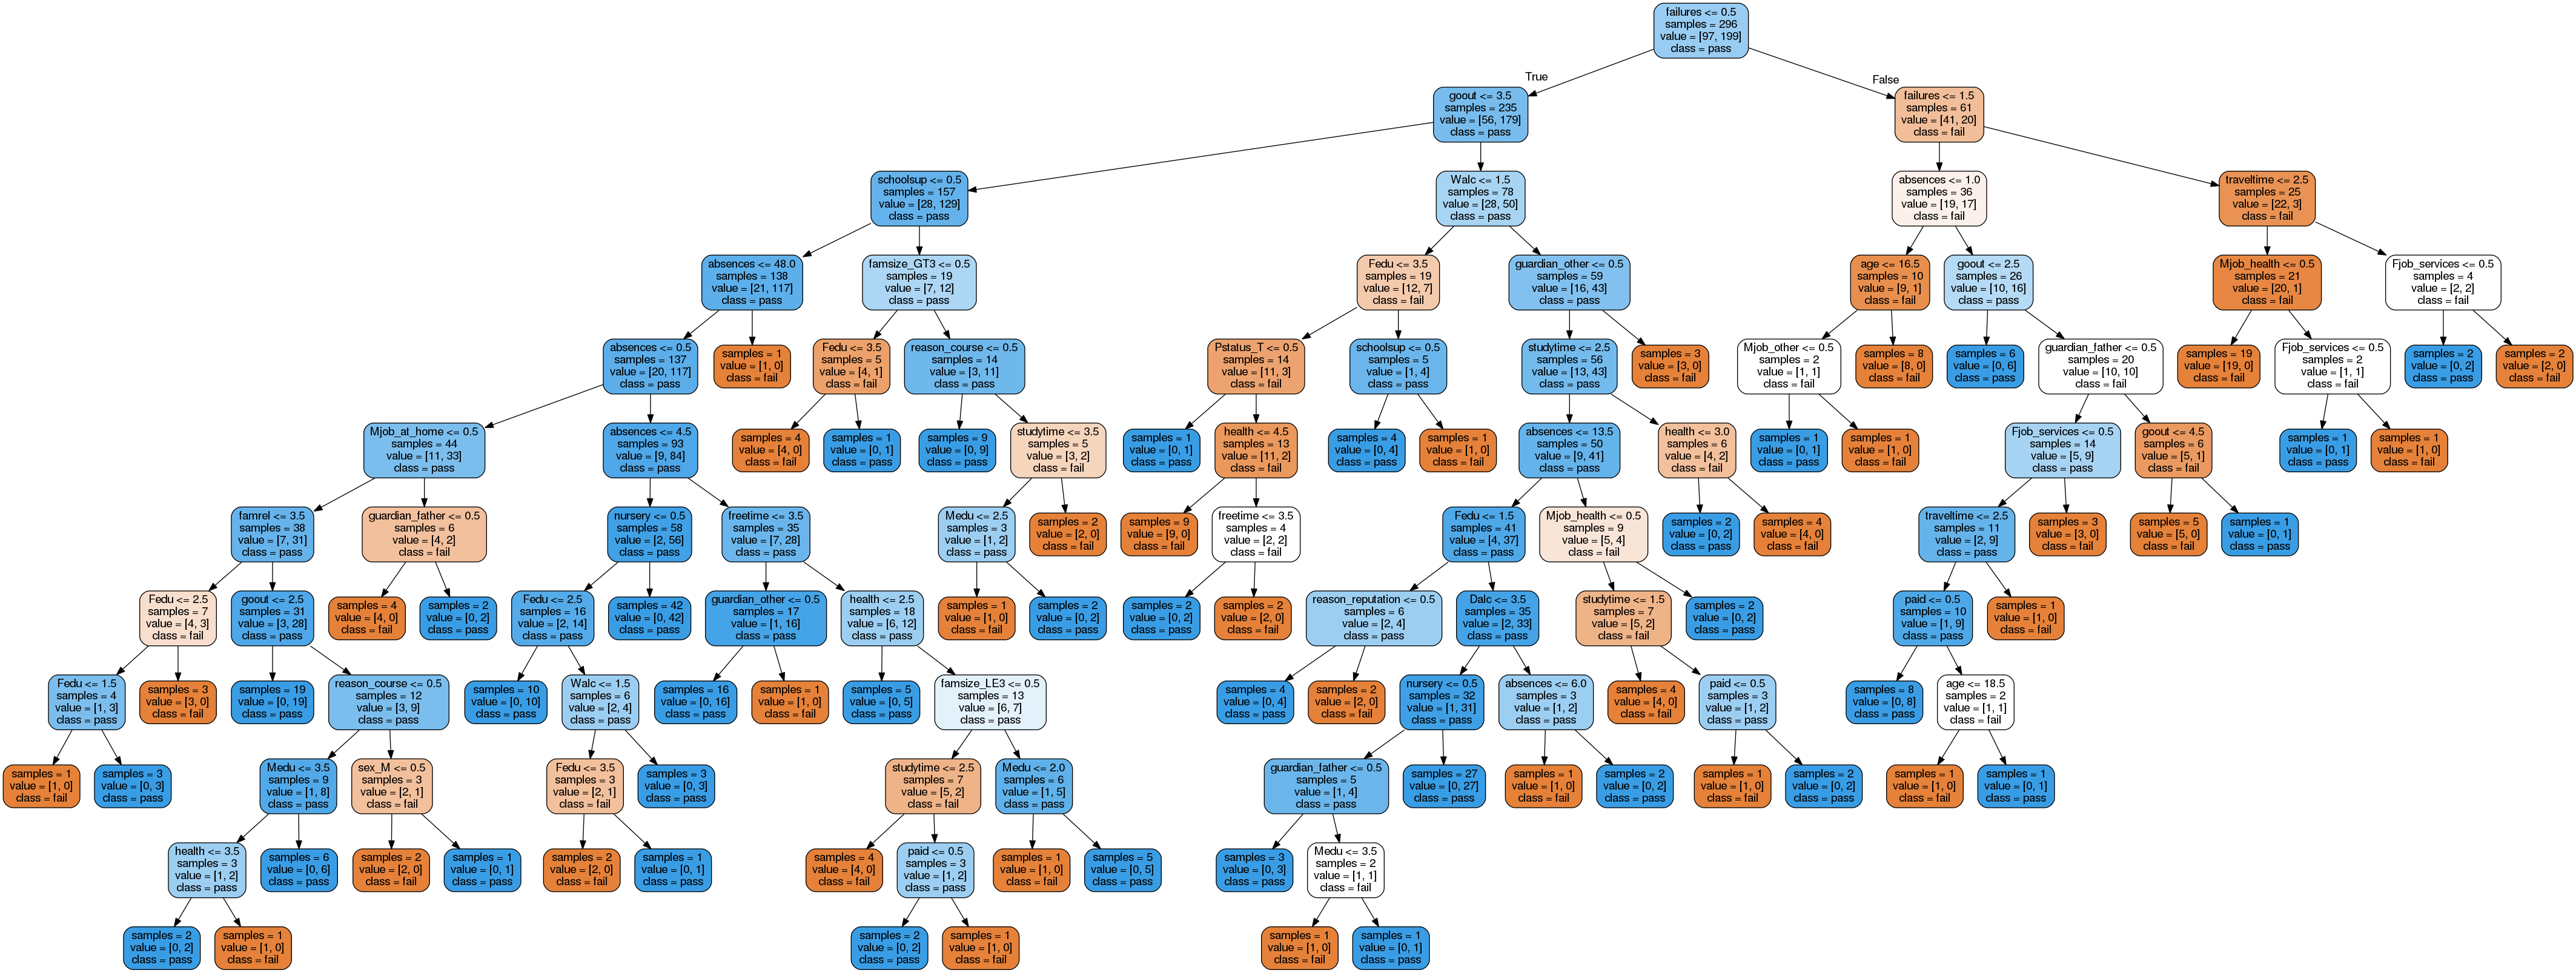

In [25]:
from IPython.display import Image
Image(filename='tree.png', width=920, height=1280)

# Random Forest

In [26]:
subset_sizes = range(100, 301, 10)

rf_model = subset_train_predict(RandomForestClassifier(),
                                         X_train, y_train,
                                         X_test, y_test,
                                         subset_sizes=subset_sizes)
rf_model

F1 score on training set: 0.9874686716791979
F1 score on test set: 0.7555555555555555
F1 score on training set: 0.99
F1 score on test set: 0.7692307692307692
F1 score on training set: 0.9822784810126581
F1 score on test set: 0.7194244604316548
F1 score on training set: 0.9797979797979797
F1 score on test set: 0.7428571428571429
F1 score on training set: 0.9900497512437811
F1 score on test set: 0.6944444444444444
F1 score on training set: 0.9874055415617129
F1 score on test set: 0.7801418439716311
F1 score on training set: 0.985
F1 score on test set: 0.7205882352941176
F1 score on training set: 0.9924812030075189
F1 score on test set: 0.7412587412587411
F1 score on training set: 0.9974811083123425
F1 score on test set: 0.786206896551724
F1 score on training set: 0.9899497487437185
F1 score on test set: 0.7777777777777778
F1 score on training set: 0.99
F1 score on test set: 0.7164179104477613
F1 score on training set: 0.9949494949494949
F1 score on test set: 0.6950354609929078
F1 score o

,F1_test,F1_train,Training_time,prediction_test_time,prediction_train_time,training_size
0,0.755556,0.987469,0.012016,0.002037,0.002306,100
1,0.769231,0.990000,0.012189,0.001666,0.002301,110
2,0.719424,0.982278,0.010667,0.001755,0.002092,120
3,0.742857,0.979798,0.011707,0.001807,0.002198,130
4,0.694444,0.990050,0.011882,0.001677,0.002095,140
5,0.780142,0.987406,0.011375,0.003289,0.002158,150
6,0.720588,0.985000,0.012180,0.001856,0.002311,160
7,0.741259,0.992481,0.011631,0.001803,0.002208,170
8,0.786207,0.997481,0.011592,0.001930,0.002356,180
9,0.777778,0.989950,0.013090,0.001794,0.002268,190


/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "upper-left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


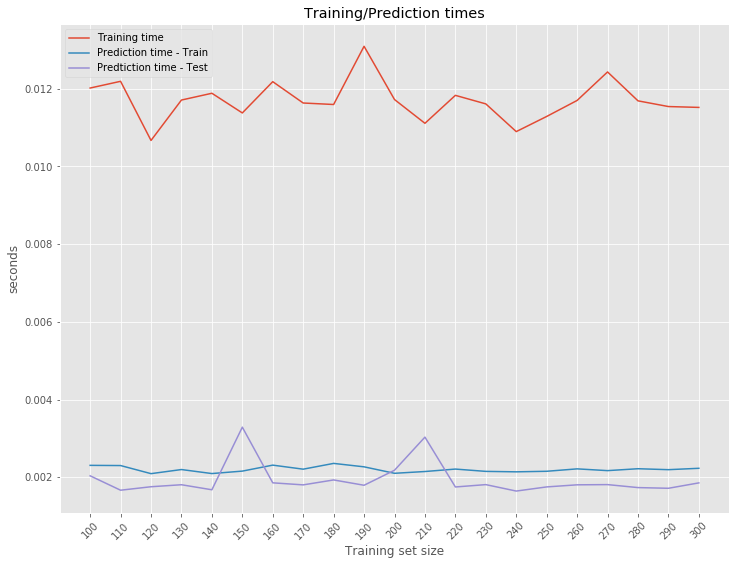

In [27]:
plot_computation_time(rf_model)

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "upper-left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


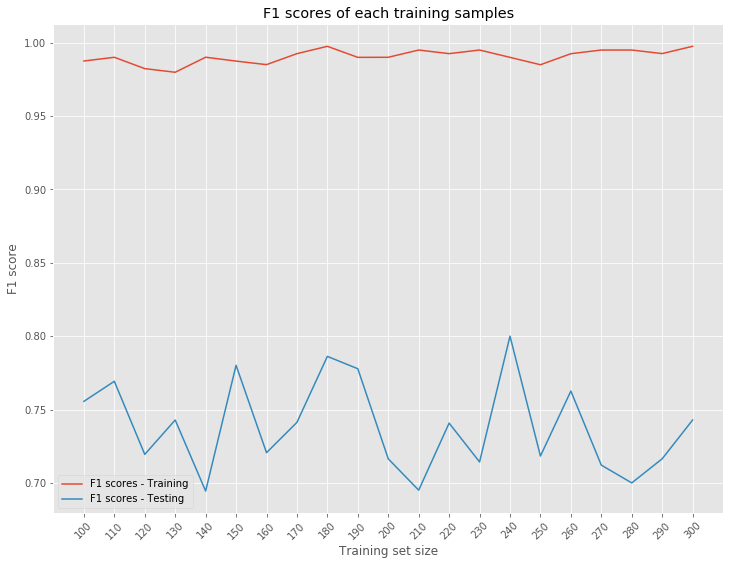

In [28]:
plot_f1_scores(rf_model)

In [29]:
rf_model, _, _ = train_evaluate(RandomForestClassifier(), X_train, y_train,
                               X_test, y_test, verbose=False)

F1 score on training set: 0.9849246231155779
F1 score on test set: 0.7857142857142858


In [30]:
rf_importances = pd.DataFrame({'Feature': X_train.columns, 
                               'Importance': rf_model.feature_importances_}, 
                             index=X_train.columns)

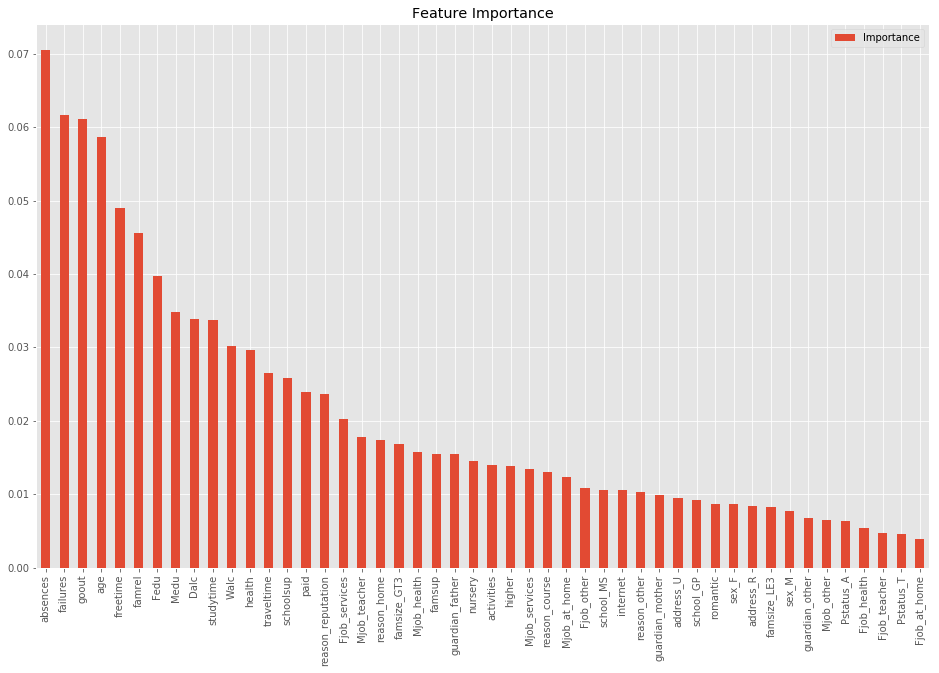

In [31]:
rf_importances.sort_values(by='Importance',
                           ascending=False).plot(kind='bar', 
                                                 figsize=(16, 10),
                                                 title='Feature Importance')
plt.show()

If we look at the feature bars then one obvious features are absences and failures. After all if carry a hypothesis to predict one student's result for the next exam then we will first ask these questions, 
1. How many days that student present in the class?
2. How is his result in the past exams, did he passed or failed from last couple of exams?

# Logistic Regression

In [39]:
# As it is a linear model, and to get the best we need to have all feature in the same scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys


In [40]:
subset_sizes = range(100, 301, 10)

lr_model = subset_train_predict(LogisticRegression(),
                               X_train, y_train,
                               X_test, y_test,
                               subset_sizes=subset_sizes)
lr_model

F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score on test set: 0.7500000000000001
F1 score on training set: 0.8443396226415094
F1 score 

,F1_test,F1_train,Training_time,prediction_test_time,prediction_train_time,training_size
0,0.75,0.84434,0.004620,0.001137,0.052506,100
1,0.75,0.84434,0.004829,0.000666,0.000890,110
2,0.75,0.84434,0.004144,0.000670,0.000879,120
3,0.75,0.84434,0.003666,0.000605,0.000806,130
4,0.75,0.84434,0.003639,0.000597,0.000766,140
5,0.75,0.84434,0.003612,0.000595,0.000920,150
6,0.75,0.84434,0.003597,0.000596,0.000724,160
7,0.75,0.84434,0.003666,0.000678,0.000736,170
8,0.75,0.84434,0.003633,0.000680,0.000741,180
9,0.75,0.84434,0.003639,0.000590,0.000801,190


/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "upper-left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


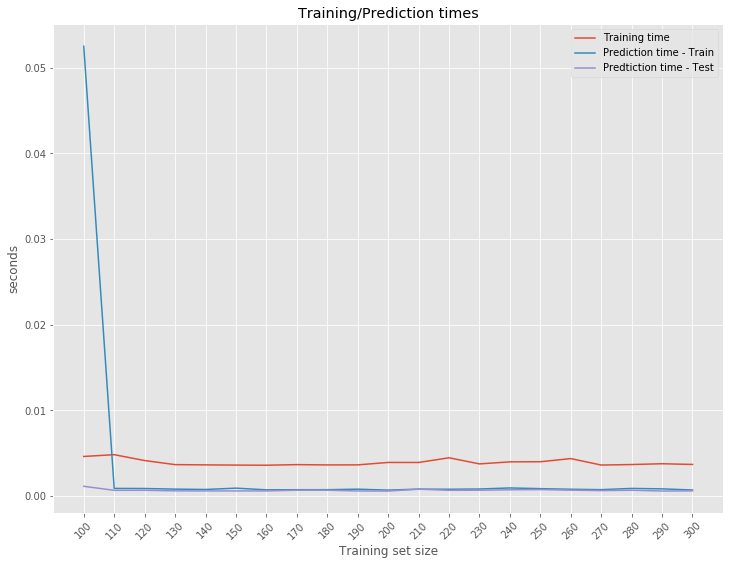

In [41]:
plot_computation_time(lr_model)

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "upper-left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


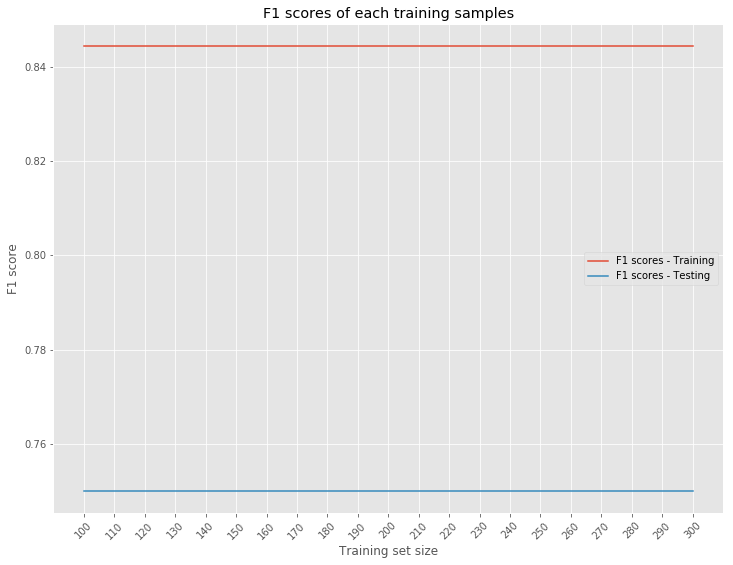

In [42]:
plot_f1_scores(lr_model)

[ISSUE]: That's really strange as the f1 score on every subset of test data is 0.75 from start to end, How this could be possible.


In [44]:
lr_models, _, _ = train_evaluate(LogisticRegression(penalty='l1'),
                               X_train_scaled, y_train,
                               X_test_scaled, y_test,
                               verbose=False)

F1 score on training set: 0.8436018957345971
F1 score on test set: 0.7552447552447552


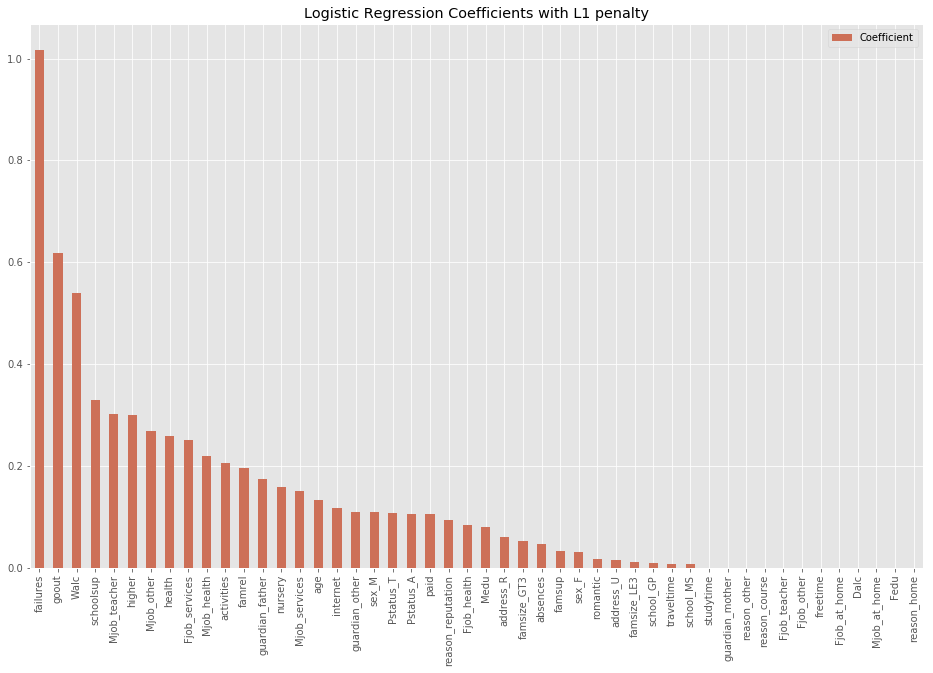

In [46]:
lr_coeffs = pd.DataFrame({'Feature': X_train.columns, 
                          'Coefficient': np.abs(lr_models.coef_[0])}, 
                             index=X_train.columns)

lr_coeffs.sort_values(by='Coefficient', 
                      ascending=False).plot(kind='bar',
                                            figsize=(16, 10),
                                            color='#cd7058',
                                            title='Logistic Regression Coefficients with L1 penalty')
plt.show()

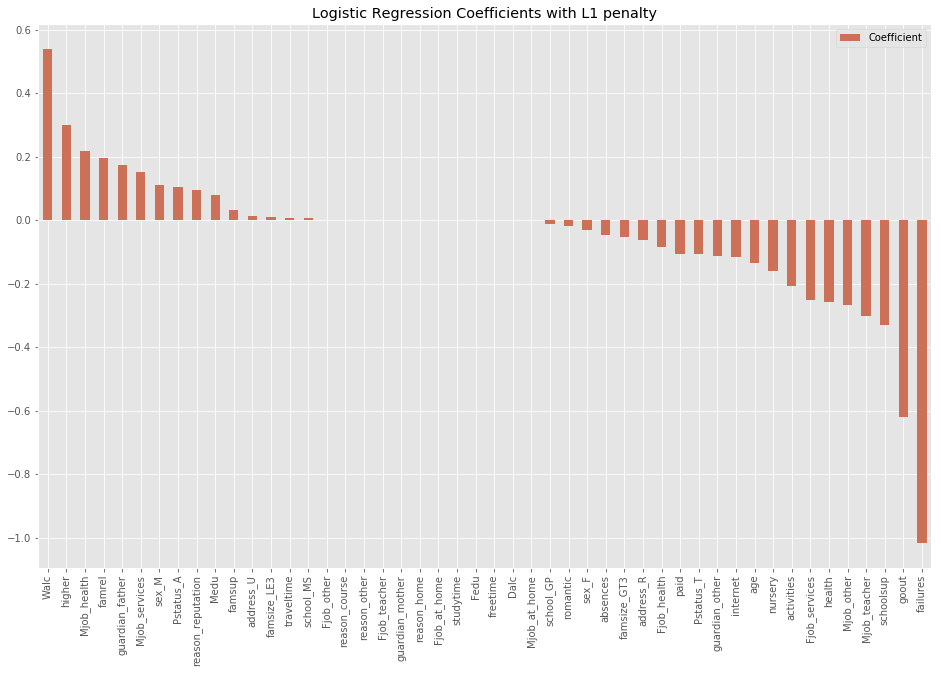

In [47]:
# let's look at +ve and -ve feature relevance score
lr_fe_coeffs = pd.DataFrame({'Feature': X_train.columns, 
                          'Coefficient': lr_models.coef_[0]}, 
                             index=X_train.columns)

lr_fe_coeffs.sort_values(by='Coefficient', 
                      ascending=False).plot(kind='bar',
                                            figsize=(16, 10),
                                            color='#cd7058',
                                            title='Logistic Regression Coefficients with L1 penalty')
plt.show()

So failures is actually negetively effect the prediction.

In [52]:
# positively corelated features
lr_fe_coeffs.sort_values(by='Coefficient', ascending=False).head()

,Feature,Coefficient
Walc,Walc,0.540461
higher,higher,0.299991
Mjob_health,Mjob_health,0.219927
famrel,famrel,0.195690
guardian_father,guardian_father,0.174728


In [53]:
# negetively corelated features
lr_fe_coeffs.sort_values(by='Coefficient', ascending=False).tail()

,Feature,Coefficient
Mjob_other,Mjob_other,-0.267731
Mjob_teacher,Mjob_teacher,-0.302446
schoolsup,schoolsup,-0.329073
goout,goout,-0.618479
failures,failures,-1.016716
